# Nghiên cứu và Xây dựng Bài toán Phát hiện và Sửa lỗi Chính tả Tiếng Việt Sử dụng Học Sâu
-------------------------------

## 1. Giới thiệu
Phát hiện và sửa lỗi chính tả là một bài toán quan trọng trong xử lý ngôn ngữ tự nhiên (NLP). Với tiếng Việt, bài toán này trở nên phức tạp hơn do cấu trúc ngôn ngữ, từ đồng âm, dấu câu, và các biến thể của từ. Bài toán này có thể được giải quyết bằng các phương pháp học sâu, bao gồm mô hình chỉ có Encoder, mô hình sinh Encoder-Decoder, hoặc mô hình chỉ sử dụng Decoder. Dưới đây là các bước cần thiết để xây dựng một hệ thống phát hiện và sửa lỗi chính tả tiếng Việt sử dụng học sâu.

## 2. Chọn Mô hình
Ta có thể lựa chọn một trong ba loại mô hình sau:

### a) Mô hình chỉ có Encoder:
Sử dụng các mô hình như BERT, RoBERTa để mã hóa câu và sau đó sử dụng các lớp đầy đủ để phát hiện và sửa lỗi.

### b) Mô hình sinh Encoder-Decoder:
Sử dụng các mô hình như Transformer hoặc seq2seq để mô hình hóa quá trình phát hiện và sửa lỗi như một bài toán dịch máy.

### c) Mô hình chỉ sử dụng Decoder:
Sử dụng các mô hình như GPT để sinh đầu ra đã được sửa từ đầu vào có lỗi.

# Library Imported

In [1]:
!python -m pip install datasets evaluate accelerate
!python -m pip install sacrebleu jiwer
!python -m pip install -U huggingface_hub

In [2]:
# !pip install transformers tokenizers datasets

from datasets import load_dataset
from tokenizers import ByteLevelBPETokenizer
from transformers import BertTokenizer, TFBertModel, GPT2TokenizerFast, AutoModelForSeq2SeqLM
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os

import random
import json
import torch
import torch.nn as nn
from functools import partial
from collections import namedtuple
from dataclasses import dataclass, field, asdict
from huggingface_hub import HfApi

import evaluate
import numpy as np
from transformers import Trainer, Seq2SeqTrainer, pipeline
from transformers import DataCollatorWithPadding, DataCollatorForSeq2Seq
from transformers import AutoTokenizer, TrainingArguments, Seq2SeqTrainingArguments

import warnings
warnings.filterwarnings("ignore")

# Dataset Loaded

In [3]:
dataset = load_dataset("PaulTran/vietnamese_spelling_error_detection")
dataset['train'] = dataset['train'].select(range(3000))
dataset = dataset['train'].train_test_split(0.3, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['input_text', 'target_text', 'tokens', 'tags', 'general_error_type'],
        num_rows: 2100
    })
    test: Dataset({
        features: ['input_text', 'target_text', 'tokens', 'tags', 'general_error_type'],
        num_rows: 900
    })
})

# Dataset Preview

In [4]:
df = pd.DataFrame(
    {
        'input_text' : dataset['train']['input_text'],
        'target_text' : dataset['train']['target_text'],
        'general_error_type' : dataset['train']['general_error_type'],
    }
)

df

,input_text,target_text,general_error_type
0,Chúng ta không thể không nhắc đến những con ng...,Chúng ta không thể không nhắc đến những con ng...,Excess Letter Error
1,Ngôn ngữ ăn chương chỉ có ở vă học,Ngôn ngữ văn chương chỉ có ở văn học,Missing Letter Error
2,"Đối với học chò, cô không chỉ là một giáo viên...","Đối với học trò, cô không chỉ là một giáo viên...",Wrong Spelling Error
3,Hoa có đòi hỏi gì không khi thơm hết cạn lòng ...,Hoa có đòi hỏi gì không khi thơm hết cạn lòng ...,No Error
4,"Giọng thơ hùng tráng, mạnh mẽ","Giọng thơ hùng tráng, mạnh mẽ",No Error
...,...,...,...
2095,"Thật vậy, từ xưa đến nay, tiền tài, danh vọng,...","Thật vậy, từ xưa đến nay, tiền tài, danh vọng,...",No Error
2096,Tràng giang là một cáh nói chệc đầy áng tạo củ...,Tràng giang là một cách nói chệch đầy sáng tạo...,Missing Letter Error
2097,"Hay nói rõ hơn là học cho tương lai, học để ma...","Hay nói rõ hơn là học cho tương lai, học để ma...",Missing Letter Error
2098,"Với tôi, tiếng Việt giúp tâm hồn tôi trong sán...","Với tôi, tiếng Việt giúp tâm hồn tôi trong sán...",No Error


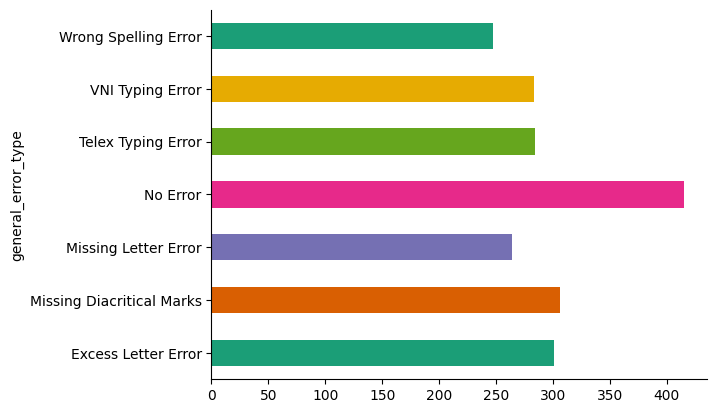

In [5]:
df.groupby('general_error_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Tokenize text

In [8]:
from huggingface_hub import interpreter_login
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token can be pasted using 'Right-Click'.
Token is valid (permission: read).


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [ ]:
MODEL_NAME = "vinai/bartpho-syllable"
MAX_LENGTH = 256

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
input_ = list(df['input_text'])
output_ = list(df['target_text'])

NameError: name 'AutoTokenizer' is not defined

In [ ]:
inputs = tokenizer(
    input_,
    text_target=output_,
    max_length=MAX_LENGTH,
    truncation=True
)

In [ ]:
def preprocess_function(examples):
    # Tokenize the text and apply truncation
    return tokenizer(examples["input_text"],
                     text_target=examples["target_text"],
                     max_length=MAX_LENGTH,
                     truncation=True,
                     )

# Apply tokenization in a batched manner for efficiency
tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names,
)

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
metric = evaluate.load("sacrebleu")

In [ ]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"sacrebleu": result["score"]}

In [ ]:
args = Seq2SeqTrainingArguments(
    do_train=True,
    do_eval=True,
    output_dir=f"somuch/vietnamese-correction-v2",
    num_train_epochs=5,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    evaluation_strategy="steps",
    eval_steps=10000,
    save_strategy="steps",
    logging_steps=10000,
    save_total_limit=5,
    predict_with_generate=True,
)

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.evaluate()

{'eval_loss': 2.2790491580963135,
 'eval_sacrebleu': 16.5472410043625,
 'eval_runtime': 2285.2501,
 'eval_samples_per_second': 0.394,
 'eval_steps_per_second': 0.049}

In [ ]:
!pip install accelerate==0.27.2

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


In [ ]:
trainer.evaluate()

In [ ]:
trainer.push_to_hub(tags="text2text-generation", commit_message="Training complete")
corrector = pipeline("text2text-generation", model="somuch/vietnamese-correction-v2")

In [ ]:
sentences_with_errors = [
    "Trời hôm nay rât là đep.",
    "Cô giáo đang giảng bài ở trong lốp học.",
    "Anh ấy đã đat được mục tiêu của mình.",
    "Mùa xuân là mùa của sự sống đơm hoa kết trái.",
    "Chúng ta sẽ tổ chức bưa tiệc vào tối nay.",
    "Mọi người đang chơi trên bải biển.",
    "Hôm qua, tôi đi chơ cùng bạn.",
    "Anh ta không muôn nói chuyện với tôi.",
    "Chiếc ô tô này rât đắt tiền.",
    "Cô ấy đang đọc một cuốn sách rât hay."
]

# Batch prediction
predictions = corrector(sentences_with_errors, max_length=MAX_LENGTH)

# Print predictions
for text, pred in zip(sentences_with_errors, predictions):
    print("- " + pred['generated_text'])